In [ ]:
#LIBRERIAS UTILIZADAS
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Modulación lora

LoRa es una modulación de espectro expandido que utiliza la técnica chirp que consiste en modular el mensaje por medio de una señal que varía la frecuencia de manera continua y lineal.

## Parámetros de la modulación

**SF (Spreading factor)**

El spreading factor define dos valores fundamentales:

- El número de chips contenidos en cada símbolo y su valor viene dado por $2^{SF}$
- El número de bits que se codifica en cada simbolo y su valor es SF.

Para este tipo de modulacion su valor esta entre [7-12]

Por ejemplo:

-  Para un SF de 7, se tiene 128 chips por simbolo.

**Ts (Symbol time)**

Tiempo que tarda en enviarse un símbolo. Se calcula como $\frac{2^{SF}}{Bw}$

**Bw (BandWidth)**

Ancho de banda definido para la transmisión

**T (Tiempo de muestra)**

Delta de tiempo en el cual se toma una muestra $T$ = $\frac{1}{Bw}$

**s (Symbol)**

Símbolo a transmitir, toma valores entre $\{0,...,2^{SF}-1\}$

# Waveform modulada

La forma de onda transmitida de duración $T_s$ para cada $s(nT_s)$ es la siguiente:

$$c(nT_s+kT) = \frac{1}{\sqrt{2^{SF}}} e^{j2\pi \left[ (s(nT_s)+k)_{mod}2^{SF}\right]kT\frac{B}{2^{SF}}}$$

$$c(nT_s+kT) = \frac{1}{\sqrt{2^{SF}}} e^{j2\pi \left[ (s(nT_s)+k)_{mod}2^{SF}\right]\frac{k}{2^{SF}}}$$

$\text{para } k=0,1,...,2^{SF}-1$

Se observa que con el incremento de k (time index), cada waveform es distinta a una waveform con frecuencia inicial 0 con un cambio de frecuencia $s(nT_s)$.

El $\Delta f$ de la forma de onda está dado por $\frac{Bw}{2^{SF}}$

Antes de mostrar la waveform de la modulacion, se van a detallar los modulos usados para generar las distintas señales pertinentes a la modulacion.

# WaveForm en frecuencia

A continuacion se muestra la forma de onda de la señal modulada en frecuencia para transmitir solo un simbolo.

Simbolo transmitido [49]


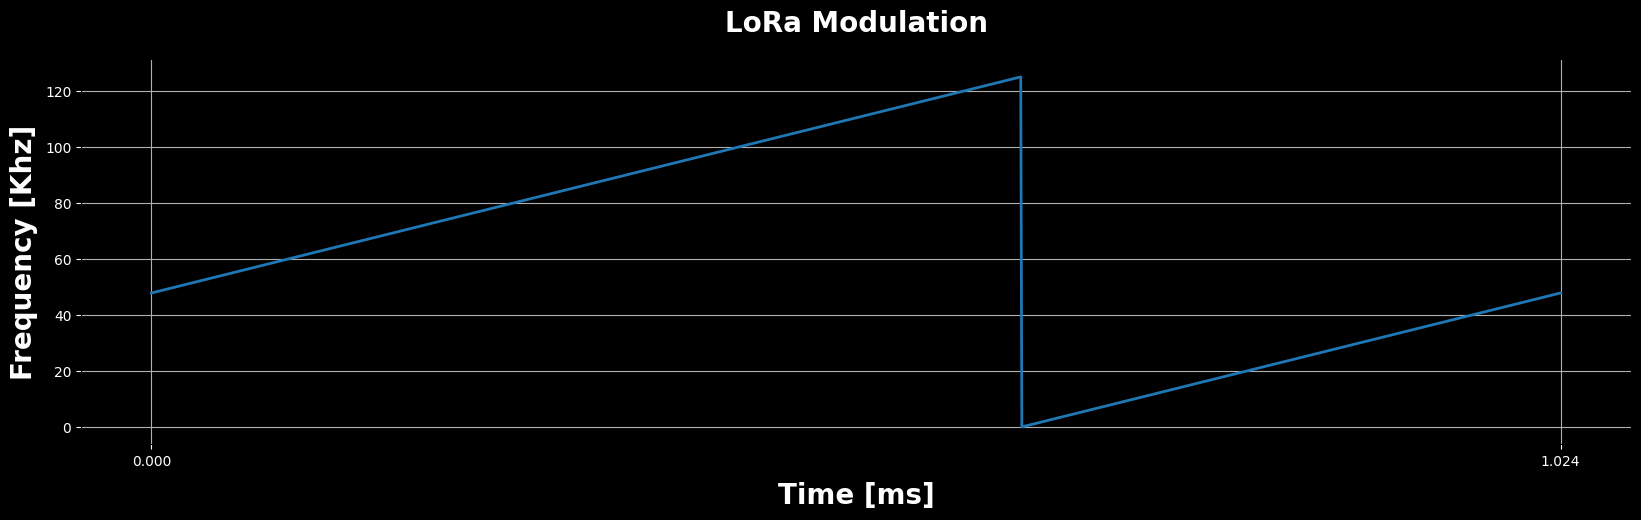

In [ ]:
#----------------------------- FUNCIONES ------------------------------------------------------------
def generate_chirp(simbolo, sf, Bw, time_interval, samples):

  M = 2**sf
  Ts = M/np.abs(Bw)
  wf_f = []

  for i in range(samples):
    wf_f.append((simbolo*np.abs(Bw)/M + Bw/Ts*time_interval[i]) % np.abs(Bw))

  return wf_f
def generate_symbols(sf, n_data, Bw, samples):

  data = []
  chirps = np.array([])
  t_c = np.linspace(0, Ts, samples)

  for i in range(n_data):
    data.append(np.random.randint(0, 2**sf))
    chirps = np.append(chirps, generate_chirp(data[i], sf, Bw, t_c, samples))

  return np.array(data), chirps

def plot_waveform(ax, t, wf, axis_x_label, axis_y_label, title, Ts, len_packet_tx):

  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
  ax.set_xticks(np.arange(0, len_packet_tx, Ts))
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
  ax.plot(t, wf, lw=2)
  ax.grid()

#------------------------------ MAIN --------------------------------------------------------------------------
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
n_data = 1 # numero de datos a transmitir
delta = 0.1
samples = int(2**sf*1/delta)
variance= 0.13

symbs, data_tx_f  = generate_symbols(sf, n_data, Bw, samples) # symbs son los datos generados aleatoriamente, data_tx son los crirp en frecuencia

print("Simbolo transmitido", symbs)
# Grafico Frecuencia vs tiempo
fig1, ax1 = plt.subplots(1, figsize = (20, 5))
fig1.patch.set_facecolor('black')

t = np.linspace(0, Ts, samples)

# Grafico Frecuencia vs tiempo
plot_waveform(ax1, t, data_tx_f, "Time [ms]", "Frequency [Khz]", "LoRa Modulation", Ts, samples)

Como se puede observar en las imagenes anteriores, el chirp se incrementa linealmente desde una frecuencia inicial (simbolo a transmitir) a una frecuencia maxima ${BW}$-$\frac{BW}{2^{SF}}$ . Una vez que llegue a la frecuencia maxima decae a la frecuencia 0 y se vuelve incrementar linealmente hasta el simbolo inicial.

# WaveForm en tiempo

A continuacion se muestra la forma de onda de la señal modulada en tiempo para transmitir solo un simbolo.

El siguiente codigo permite generar la waveform en tiempo con ruido gaussiano y sin ruido para ver las diferencias.

Parametros:
  - symb: Simbolo a transmitir (representa la frecuencia inicial de la waveform)
  - sf: spreading factor
  - Bw: ancho de banda del canal.
  - samples: Numero de muestras.

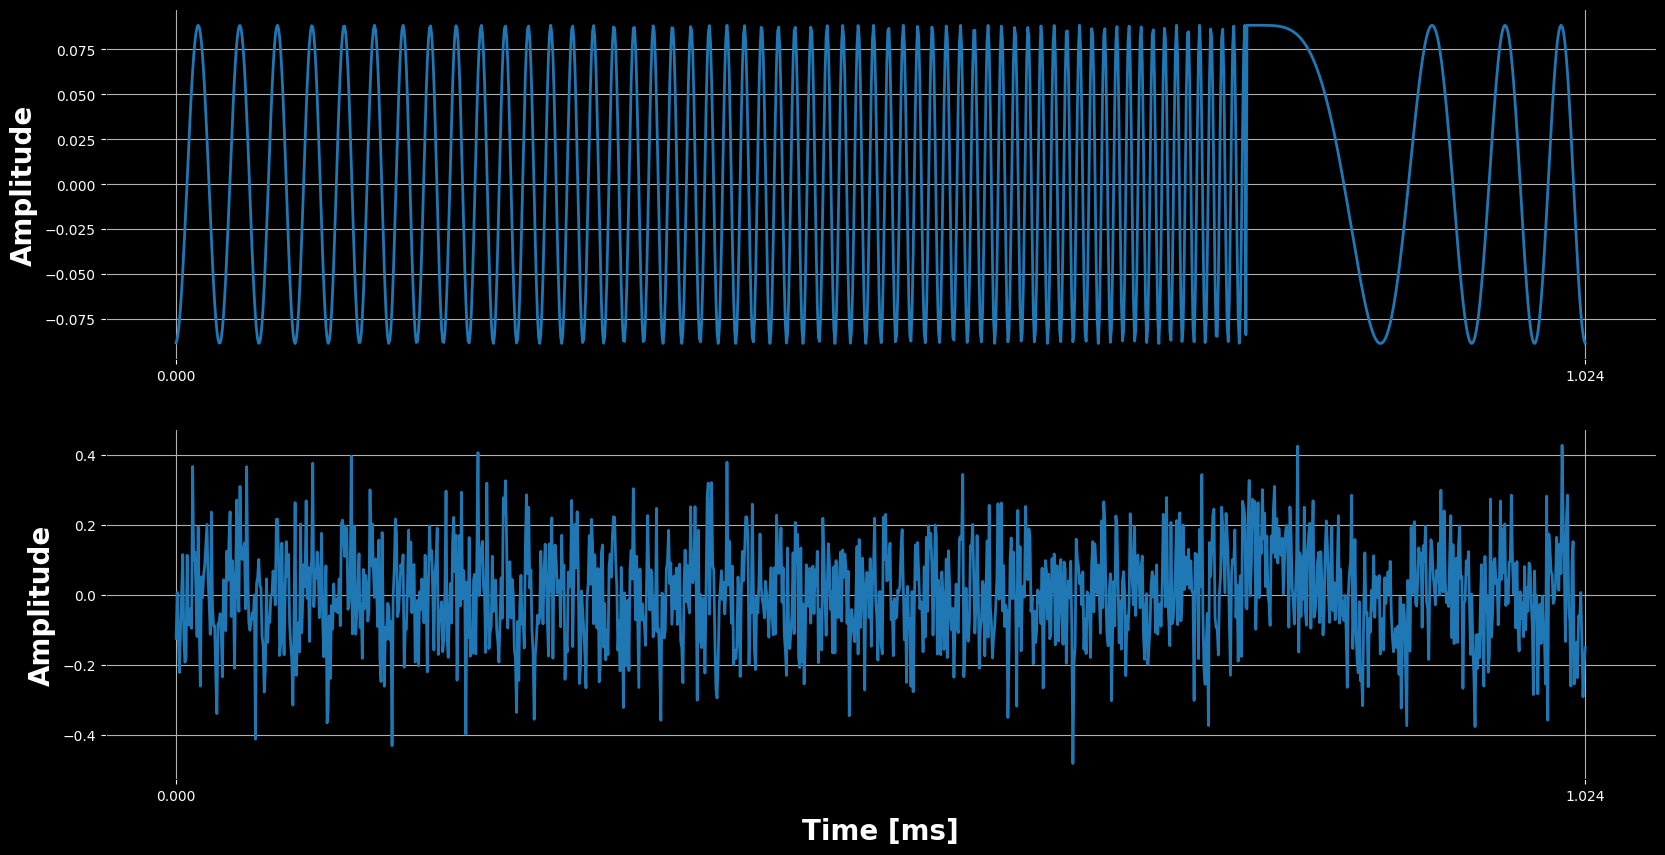

In [ ]:
#---------------------------------------------FUNCIONES-----------------------------------------------------
def waveform_chirp_time(symb, sf, Bw, delta, samples):

  Ts =2**sf
  T = 1/Bw
  wf = np.array([])

  fMax = (2**sf-1)*Bw/(2**sf)
  k = symb

  for n in range(samples):
    f = k*Bw/(2**sf)
    t = k*T
    if (f > fMax):
      k = k-Ts
      f = k*Bw/(2**sf)

    sample = (1/(np.sqrt(2**sf)))*np.exp(1j*2*np.pi*f*t*1/2)
    wf = np.append(wf, sample)

    k += delta

  return  wf
def add_noise_gaussiano(tx_signal, mean, variance):

  wn = generate_awgn(mean, variance, len(tx_signal))
  rx_signal = (tx_signal + wn)

  return rx_signal

def generate_awgn(mean, variance, samples):
  return np.random.normal(mean, variance, samples) #creando muestra de ruido

def plot_waveform(ax, t, wf, axis_x_label, axis_y_label, title, Ts, len_packet_tx):

  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
  ax.set_xticks(np.arange(0, len_packet_tx, Ts))
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
  ax.plot(t, wf, lw=2)
  ax.grid()

#---------------------------------------------MAIN----------------------------------------------------------
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
delta = 0.1
samples = int(2**sf*1/delta)
variance = 0.13

packet_tx_t = np.array([]) #waveform en tiempo

symb = 30 # simbolo a transmitir

packet_tx_t = np.append(packet_tx_t, waveform_chirp_time(symb, sf, Bw, delta, samples)) # chirp en tiempo

# Grafico Amplitud vs tiempo sin ruido gaussiano

fig1, [ax1, ax2] = plt.subplots(2, figsize = (20, 10))
fig1.patch.set_facecolor('black')

t = np.linspace(0, Ts, samples)

plot_waveform(ax1, t, np.real(packet_tx_t), "", "Amplitude", "", Ts, samples)

# Grafico Amplitud vs tiempo sin ruido gaussiano

rx_signal = add_noise_gaussiano(packet_tx_t, 0, variance) # waveform en tiempo con ruido gaussiano
plot_waveform(ax2, t, np.real(rx_signal), "Time [ms]", "Amplitude", "", Ts, samples)

Como se muestra en la imagen anterior, la forma de onda responde de la misma forma que la grafica anterior en frecuencia mostrada.

# Transmision paquete completo de LoRa

Apartir de lo mostrado anteriormente sobre las formas de onda en frecuencia y tiempo para la transmision de un solo simbolo, en este apartado se va a mostrar la transmision de un paquete completo, incluye simbolo de preambulo, simbolo de sincronizacion y los datos mismos.

Se generan las waveform con 4 up-chirp de preambulo, 2 down-chirp de sincronizacion y 6 chirp de datos.

Aclaracion, se puede ajustar la cantidad de chirp de preambulo y de sincronizacion, siempre y cuando tanto el transmisor y receptor conozcan el mismo protocolo.

El siguiente codigo muestra la modulacion completa LoRa

<ipython-input-25-356521c54e0d>:146: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax1.stem(symbs[0:n_data], use_line_collection = True)


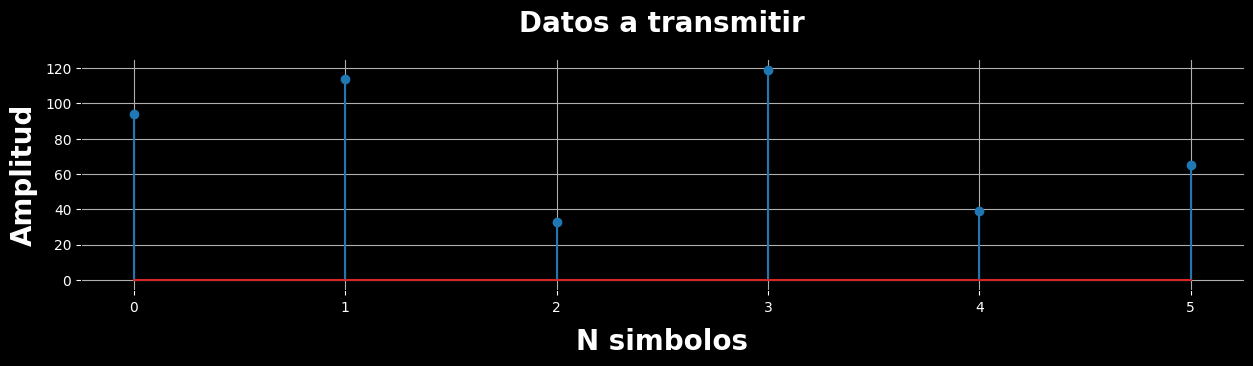

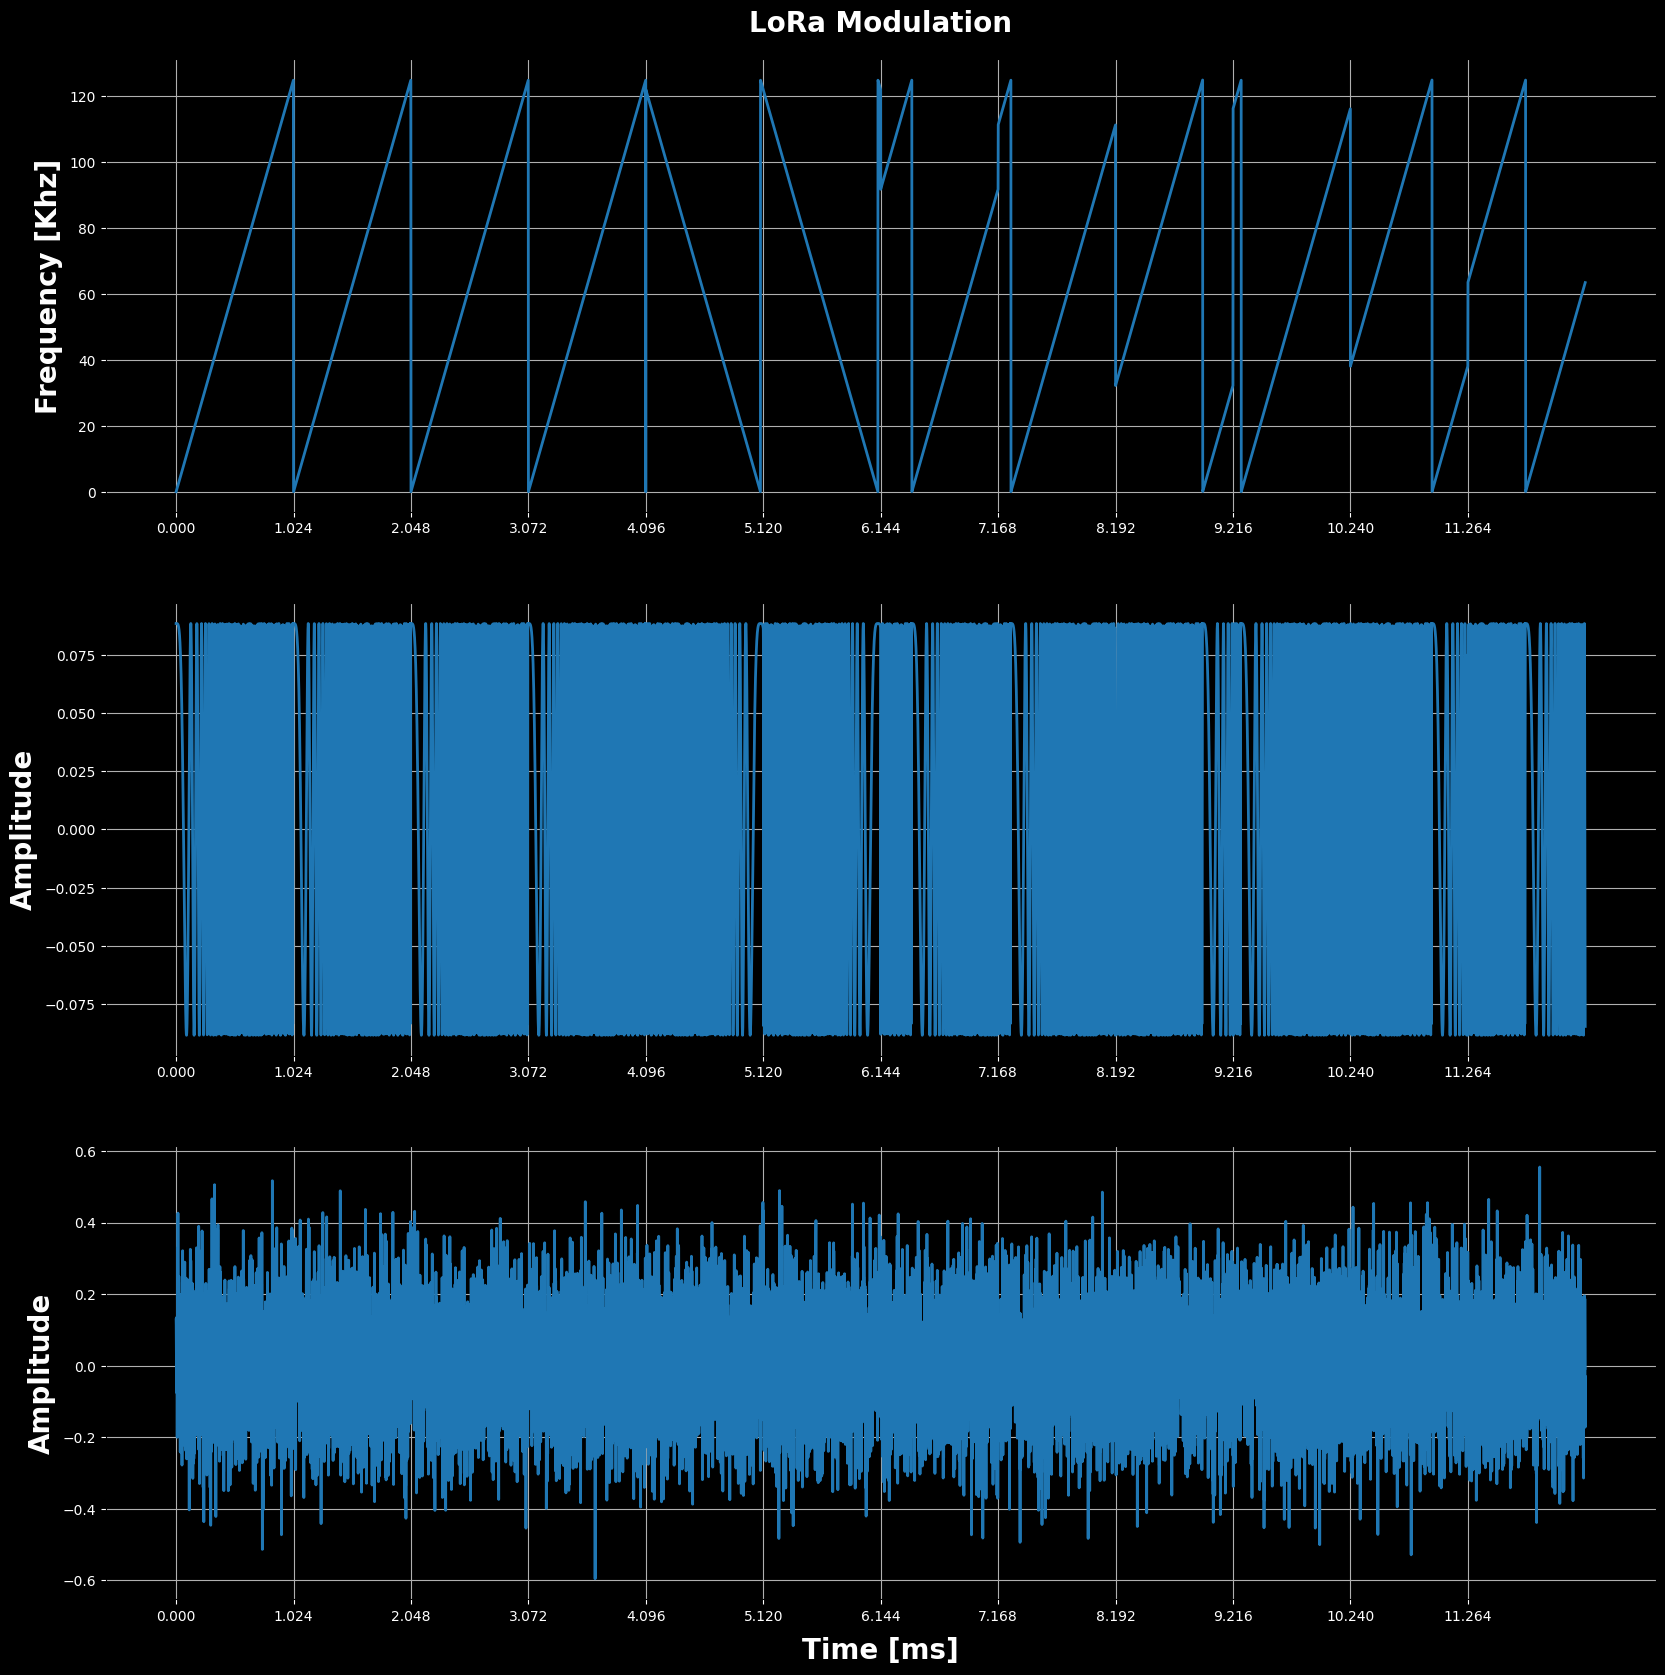

In [ ]:
#----------------------------- FUNCIONES ------------------------------------------------------------
# Genera el chirp de acuerdo al simbolo recibido: puede ser up-chirp, down-chirp
def generate_chirp(simbolo, sf, Bw, time_interval, samples):

  M = 2**sf
  Ts = M/np.abs(Bw)
  wf_f = []

  for i in range(samples):
    wf_f.append((simbolo*np.abs(Bw)/M + Bw/Ts*time_interval[i]) % np.abs(Bw))

  return wf_f
# Genera los simbolos aleatoriamente
def generate_symbols(sf, n_data, Bw, samples):

  data = []
  chirps = np.array([])
  t_c = np.linspace(0, Ts, samples)

  for i in range(n_data):
    data.append(np.random.randint(0, 2**sf))
    chirps = np.append(chirps, generate_chirp(data[i], sf, Bw, t_c, samples))

  return np.array(data), chirps

# Genera el simbolo de sincronizacion
def generate_sync(length_sync, Bw, sf, samples):

  f_0 = Bw
  M = 2**sf
  Ts = M/Bw

  sync = np.array([])
  t_c = np.linspace(0, Ts, samples)

  for i in range(length_sync):
    sync = np.append(sync, generate_chirp(f_0, sf, -Bw,  t_c, samples))

  return sync

def generate_preamble(length_preamb, Bw, Ts, samples):

  f_0 = 0
  preamble = np.array([])
  t_c = np.linspace(0, Ts, samples)

  for i in range(length_preamb):
    preamble = np.append(preamble, generate_chirp(f_0, sf, Bw,  t_c, samples))

  return preamble

def concatenate_chirps(preamble, sync, data_tx, Ts, samples, len_packet_tx):

  packet_tx = np.array([])
  packet_tx2 = np.array([])
  t = np.linspace(0, len_packet_tx*Ts, len_packet_tx*samples)

  tx_packet = np.append(preamble, sync)
  packet_tx2 = np.append(tx_packet, data_tx)

  return packet_tx2, t

def waveform_chirp_time(symb, sf, Bw, delta, samples):

  Ts =2**sf
  T = 1/Bw
  wf = np.array([])

  fMax = (2**sf-1)*Bw/(2**sf)
  k = symb

  for n in range(samples):
    f = k*Bw/(2**sf)
    t = k*T
    if (f > fMax):
      k = k-Ts
      f = k*Bw/(2**sf)

    sample = (1/(np.sqrt(2**sf)))*np.exp(1j*2*np.pi*f*t*1/2)
    wf = np.append(wf, sample)

    k += delta

  return  wf

def add_noise_gaussiano(tx_signal, mean, variance):

  wn = generate_awgn(mean, variance, len(tx_signal))
  rx_signal = (tx_signal + wn)

  return rx_signal

def generate_awgn(mean, variance, samples):
  return np.random.normal(mean, variance, samples) #creando muestra de ruido

def plot_waveform(ax, t, wf, axis_x_label, axis_y_label, title, Ts, len_packet_tx):

  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')
  ax.set_xticks(np.arange(0, len_packet_tx, Ts))
  ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
  ax.plot(t, wf, lw=2)
  ax.grid()
def simple_plot(ax, fig, axis_x_label, axis_y_label, title):
  fig.set_facecolor('black')
  ax.set_facecolor('black')
  ax.set_title(title, fontdict={'color':'white','weight':'bold','size' : 20}, pad = 20)
  ax.set_xlabel(axis_x_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 10)
  ax.set_ylabel(axis_y_label, fontdict={'color':'white','weight':'bold','size' : 20}, labelpad = 5)
  ax.tick_params(axis='both', which='major', labelsize=10, colors='white')

#---------------------------------MAIN---------------------------------------------------------------

# PARAMETROS A UTILIZAR
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
n_data = 6 # numero de datos a transmitir
len_preamb = 4 # Tamaño del preambulo
len_sync = 2 # Tamaño de down-chirp de sincronizacion
len_preamb_sync = len_preamb + len_sync
len_packet_tx = n_data+len_preamb_sync # Tamaño del paquete a transmitir
delta = 0.1
samples = int(2**sf*1/delta)
variance= 0.13

# Arreglos de los simbolos a transmitirse
packet_symbs_t = np.array([])
packet_preamb_t = np.array([])
packet_sync_t = np.array([])
packet_full_tx_t = np.array([])

# Se generan los distintos chirp
symbs, data_tx_f  = generate_symbols(sf, n_data, Bw, samples)
preamble        = generate_preamble(len_preamb, Bw, Ts, samples)
sync            = generate_sync(len_sync, Bw, sf, samples)
packet_tx_f, t  = concatenate_chirps(preamble, sync, data_tx_f, Ts, samples, len_packet_tx)

# Se muestran los datos a transmitir generados aleatoriamente
fig1, ax1 = plt.subplots(1, figsize=(15, 3))
xt = np.linspace(0, n_data, n_data)
simple_plot(ax1,fig1,'N simbolos','Amplitud','Datos a transmitir')
ax1.stem(symbs[0:n_data], use_line_collection = True)
ax1.grid()

# Se generan las waveform en tiempo
for i in range(n_data):
    packet_symbs_t = np.append(packet_symbs_t, waveform_chirp_time(symbs[i], sf, Bw, delta, samples))

for j in range(len_preamb):
    packet_preamb_t = np.append(packet_preamb_t, waveform_chirp_time(0, sf, Bw, delta, samples))

for k in range(len_sync):
    packet_sync_t = np.append(packet_sync_t, waveform_chirp_time(-Bw, sf, Bw, delta, samples))


packet_full_tx_t = np.append(packet_full_tx_t, packet_preamb_t)
packet_full_tx_t = np.append(packet_full_tx_t, packet_sync_t)
packet_full_tx_t = np.append(packet_full_tx_t, packet_symbs_t)

# Se añade el ruido gaussiano
rx_signal = add_noise_gaussiano(packet_full_tx_t, 0, variance)

# Se grafica las distintas waveform
fig3, [ax2, ax3, ax4] = plt.subplots(3, figsize=(20, 20))
fig3.patch.set_facecolor('black')

# Grafico Amplitud vs tiempo
t2 = np.linspace(0, Ts*len_packet_tx, len_packet_tx*samples)

# Grafico sin ruido gaussiano
plot_waveform(ax3, t2, np.real(packet_full_tx_t), "", "Amplitude", "", Ts, len_packet_tx)

# Grafico con ruido gaussiano
plot_waveform(ax4, t2, np.real(rx_signal), "Time [ms]", "Amplitude", "", Ts, len_packet_tx)

# Grafico frecuencia vs tiempo
plot_waveform(ax2, t, packet_tx_f, "", "Frequency [Khz]", "LoRa Modulation", Ts, len_packet_tx)

# Demodulacion OPTIMA

Para poder demodular la señal, se realiza la comparacion del simbolo recibido por cada una de las funciones bases $2^{SF}$.

Esta comparacion se realiza mediante la correlacion entre dos señales y se elige aquel simbolo que maximice la siguiente ecuacion:
$$\sum_{k=0}^{2^{SF}-1} r(nT_s+kT).c^*(nT_s+kT)\hspace{4mm}$$

Donde c* es la funcion base.

Este forma de demodular recibe el nombre de filtro acoplado, correlador.

Error de simbolos 0.0
Simbolo transmitido  94
Simbolo estimado 94
Simbolo transmitido  114
Simbolo estimado 114
Simbolo transmitido  33
Simbolo estimado 33
Simbolo transmitido  119
Simbolo estimado 119
Simbolo transmitido  39
Simbolo estimado 39
Simbolo transmitido  65
Simbolo estimado 65


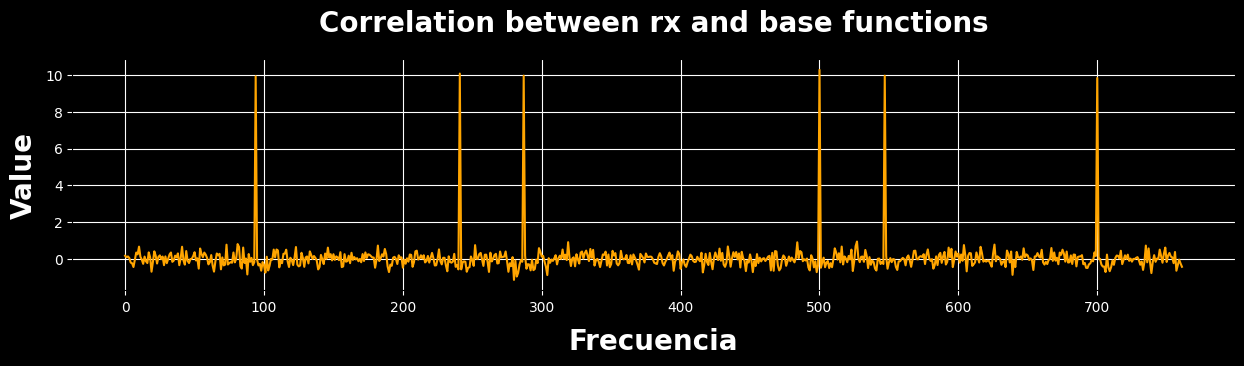

In [ ]:
#-----------------------------------------------------FUNCIONES------------------------------------------------------------------------
# Genera la waveform en tiempo de la funcion base para correlacionar con la rx_signal
def gen_waveform_dem(symb ,sf, Bw, delta, samples):

  Ts =2**sf
  T = 1/Bw
  wf = []

  fMax = (2**sf-1)*Bw/(2**sf)
  k = symb

  for n in range(samples):
    f = k*Bw/(2**sf)
    t = k*T
    if (f > fMax):
      k = k-Ts
      f = k*Bw/(2**sf)
    sample = (1/(np.sqrt(2**sf)))*np.exp(-1j*2*np.pi*f*t*1/2)
    wf.append(sample)

    k += delta
  return  wf

def correlate_base_function(rx_waveform_t, f_base):
  return np.dot(rx_waveform_t, f_base)

# Demodula la señal recibida (generada anteriormente)
def demodulate_waveform(rx_signal, sf, Bw, delta, samples, n_data, len_preamb_sync):
  rx_symbol = []
  corr = []
  max = 0

  for i in range(n_data):
    for f in range(2**sf-1):
      func_base = gen_waveform_dem(f, sf, Bw, delta, samples)
      corr_temp = correlate_base_function(rx_signal[(len_preamb_sync*samples) + i*samples: samples+i*samples + (len_preamb_sync*samples)], func_base)
      corr.append(corr_temp)

      if (corr_temp > max):
        max = corr_temp
        symbol = f

    max = 0
    rx_symbol.append(symbol)
  return rx_symbol, corr
# Calcula la cantidad de errores de simbolos
def decisor_rx_symbol(tx_signal, rx_estimado, n_data):

  error = 0
  for i in range(n_data):
    if (tx_signal[i] != rx_estimado[i]):
      error +=1
  return error/n_data



#----------------------------------------------------------MAIN--------------------------------------------------------------------------
# PARAMETROS A UTILIZAR
sf = 7 #Spreading factor
Bw = 125 #Khz
Ts = 2**sf/Bw #Tiempo de simbolo
n_data = 6 # numero de datos a transmitir
len_preamb = 4 # Tamaño del preambulo
len_sync = 2 # Tamaño de down-chirp de sincronizacion
len_preamb_sync = len_preamb + len_sync
len_packet_tx = n_data+len_preamb_sync # Tamaño del paquete a transmitir
delta = 0.1
samples = int(2**sf*1/delta)
variance= 0.13

rx_symbol, corr = demodulate_waveform(rx_signal, sf, Bw, delta, samples, n_data, len_preamb_sync)
error = decisor_rx_symbol(symbs, rx_symbol, n_data)

print("Error de simbolos", error)

for i in range(n_data):
    print("Simbolo transmitido ", symbs[i])
    print("Simbolo estimado", rx_symbol[i])

fig3, ax5 = plt.subplots(1, figsize=(15, 3))
simple_plot(ax5,fig3,'Frecuencia','Value','Correlation between rx and base functions')
ax5.plot(np.real(corr), color = 'orange')
ax5.grid(color = 'white')
plt.show()

A partir de la imagen anterior, cabe aclarar que representa todos los valores de correlacion, por lo que se debe tener cuidado al analizarlo. Por ejemplo en la frecuencia 200 no significa donde se encontro el mayor match.

Si se grafica solo una correlacion de un simbolo recibido ahi se ve claramente en la frecuencia donde ocurre el match.


# Espectrograma

El espectrograma puede definirse como un gráfico de intensidad de la magnitud de la transformada de Fourier de tiempo corto (STFT). La STFT es simplemente una secuencia de FFTs de segmentos de datos divididos en ventanas, donde las ventanas suelen solaparse en el tiempo, normalmente en un 25-50%.

Un espectrograma muestra la intensidad de la señal utilizando colores: cuanto más brillante sea el color, mayor será la energía de la señal.

Generalizando y resumiendo lo que es un espectrograma, muestra como se distribuye la intensidad de la señal en cada frecuencia que se encuentra en la señal.

A continuacion se llama a la funcion que implementa el espectrograma, se utilizo la funcion provista por python llamada spectrogram.


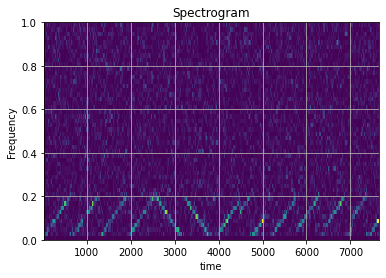

In [ ]:
def plot_spectrogram(title, rx_waveform_t, samples):
  ff, tt, Sxx = spectrogram(rx_waveform_t , fs =samples, nperseg=100, noverlap=50, mode='psd')
  plt.pcolormesh(tt, ff, Sxx)
  plt.title(title)
  plt.xlabel('time')
  plt.ylabel('Frequency')
  plt.axis(ymax = 1)
  plt.grid()

plot_spectrogram("Spectrogram", np.real(rx_signal), samples=2)
plt.show()

A partir de la imagen anterior se puede concluir donde hay mas luminosidad es donde se concentra la mayor energia. A demas se ve claramente el paquete transmitido como una secuencia de up-chirp y down-chirp.

Si se saca el ruido gaussiano a la señal transmitida, en el espectrograma se veria mas clara la imagen y con mayor intensidad de color.

In [ ]:
import numpy as np
from scipy.stats import norm

def p_gamma(h, rho, sigma2, gamma, q, coherent=True):
    q_squared = q**2
    h_squared = np.abs(h)**2

    if coherent:
        pd_term = norm.cdf(q_squared / (2 * rho * sigma2 * gamma) - q_squared / (2 * rho * sigma2))
    else:
        pd_term =

    return np.prod(pd_term)

# Ejemplo de uso
k = 3  # valor arbitrario
gamma = 0.5  # valor arbitrario
q = 1.5  # valor arbitrario
rho = 0.8  # valor arbitrario
sigma2 = 0.2  # valor arbitrario
h = np.random.normal(0, 1) + 1j * np.random.normal(0, 1)  # número complejo aleatorio

pd_result = p_gamma(h, rho, sigma2, gamma, q, coherent=True)
print("PD para detección coherente:", pd_result)


PD para detección coherente: 0.9999999999989766


In [ ]:
import numpy as np
from scipy.special import binom
from scipy.stats import norm

def PD(k, N, rho, sigma):
    result = 0

    for i in range(k, N+1):
        h = np.random.normal(0, 1)
        pd_term = binom(N, i) * (norm.sf(np.sqrt(2/(rho*sigma**2)) - np.sqrt(2*rho/sigma**2)))**i * (1 - norm.sf(np.sqrt(2/(rho*sigma**2)) - np.sqrt(2*rho/sigma**2)))**(N-i)
        result += pd_term
        print(f"PD acumulada en iteración {i}: {result}")

    return result

# Ejemplo de uso
k = 0
N = 8
rho = 0.8
sigma = 0.2

# Generar h aleatorio siguiendo una distribución gaussiana compleja simétrica circular

print(h)
pd_result = PD(k, N, rho, sigma)
print("PD Final:", pd_result)


(-1.1302697311630752-0.8068976135565579j)
PD acumulada en iteración 0: 0.625715160207973
PD acumulada en iteración 1: 0.9278553496147524
PD acumulada en iteración 2: 0.9916843986595042
PD acumulada en iteración 3: 0.999389710195198
PD acumulada en iteración 4: 0.9999710660467914
PD acumulada en iteración 5: 0.9999991380799278
PD acumulada en iteración 6: 0.9999999852794552
PD acumulada en iteración 7: 0.9999999998897673
PD acumulada en iteración 8: 1.0000000000000002
PD Final: 1.0000000000000002


In [ ]:
import numpy as np
from scipy.special import binom
from scipy.stats import norm

def rho_from_snr(snr_dB):
    snr = 10**(snr_dB / 10.0)
    rho = snr / (snr + 1)
    return rho

def PD(k, N, snr_dB, sigma,gamma):
    rho = rho_from_snr(snr_dB)
    result = 0

    for i in range(k, N+1):
        pd_term = binom(N, i) * (norm.sf(np.sqrt(2/(rho*sigma**2))*gamma - np.sqrt(2*rho/sigma**2)))**i * (1 - norm.sf(np.sqrt(2/(rho*sigma**2))*gamma - np.sqrt(2*rho/sigma**2)))**(N-i)
        result += pd_term
        print(f"PD acumulada en iteración {i}: {result}")

    return result

def PF(k, N, snr_dB, sigma,gamma):
    rho = rho_from_snr(snr_dB)
    result = 0

    for i in range(k, N+1):
        pf_term = binom(N, i) * (norm.sf(np.sqrt(2/(rho*sigma**2))*gamma ))**i * (1 - norm.sf(np.sqrt(2/(rho*sigma**2))*gamma))**(N-i)
        result += pf_term
        print(f"PF acumulada en iteración {i}: {result}")

    return result

# Ejemplo de uso
k = 3
N = 8
snr_dB = 20  # Puedes ajustar este valor según la aplicación
sigma = 1
gamma = 1.2


pd_result = PD(k, N, snr_dB, sigma , gamma)
print("PD Final:", pd_result)

pf_result = PF(k, N, snr_dB, sigma, gamma)
print("PF Final:", pf_result)


PD acumulada en iteración 3: 0.28134661041937126
PD acumulada en iteración 4: 0.4994007335098397
PD acumulada en iteración 5: 0.6075607868211726
PD acumulada en iteración 6: 0.6410920179855587
PD acumulada en iteración 7: 0.6470321221128752
PD acumulada en iteración 8: 0.6474925023515485
PD Final: 0.6474925023515485
PF acumulada en iteración 3: 0.003820904478172369
PF acumulada en iteración 4: 0.004040980907356638
PF acumulada en iteración 5: 0.004049093522150826
PF acumulada en iteración 6: 0.004049280430282704
PF acumulada en iteración 7: 0.004049282890976021
PF acumulada en iteración 8: 0.00404928290514912
PF Final: 0.00404928290514912


In [ ]:
import numpy as np
from scipy.special import binom
from scipy.stats import norm

def rho_from_snr(snr_dB):
    snr = 10**(snr_dB / 10.0)
    rho = snr / (snr + 1)
    return rho


def PD(k, N, snr_dB, sigma,gamma):
    rho = rho_from_snr(snr_dB)
    result = 0

    for i in range(k, N+1):
        pd_term = binom(N, i) * (norm.sf(np.sqrt(2/(rho*sigma**2))*gamma - np.sqrt(2*rho/sigma**2)))**i * (1 - norm.sf(np.sqrt(2/(rho*sigma**2))*gamma - np.sqrt(2*rho/sigma**2)))**(N-i)
        result += pd_term
        #print(f"PD acumulada en iteración {i}: {result}")

    return result

def PF(k, N, snr_dB, sigma, gamma):
    rho = rho_from_snr(snr_dB)
    result = 0

    for i in range(k, N+1):
        pf_term = binom(N, i) * (norm.sf(np.sqrt(2/(rho*sigma**2))*gamma ))**i * (1 - norm.sf(np.sqrt(2/(rho*sigma**2))*gamma))**(N-i)
        result += pf_term
        #print(f"PF acumulada en iteración {i}: {result}")

    return result

def find_gamma_for_pf_target(k, N, snr_dB, sigma, target_pf):
    def objective_function(gamma):
        return PF(k, N, snr_dB, sigma, gamma) - target_pf

    gamma_lower_bound = 0.1
    gamma_upper_bound = 10.0

    while gamma_upper_bound - gamma_lower_bound > 1e-6:
        gamma_mid = (gamma_lower_bound + gamma_upper_bound) / 2
        if objective_function(gamma_mid) < 0:
            gamma_upper_bound = gamma_mid
        else:
            gamma_lower_bound = gamma_mid

    return (gamma_lower_bound + gamma_upper_bound) / 2


def calcular_k_optimizado(N, snr_dB, sigma, alfa):
  kmax = 0
  pdmax = 0
  for k in range(1,N):
    pdtemp = PD(k, N, snr_dB, sigma,find_gamma_for_pf_target(k, N, snr_dB, sigma, alfa))
    print(pdtemp)
    if pdtemp> pdmax:
      pdmax = pdtemp
      kmax = k

  print(kmax)
  return kmax

# Ejemplo de uso
k = 3
N = 8
snr_dB = 20  # Puedes ajustar este valor según la aplicación
sigma = 1
target_pf = 1e-3

gamma_solution = find_gamma_for_pf_target(k, N, snr_dB, sigma, target_pf)

argumento_pd = PD(7,N,snr_dB,sigma,gamma_solution)

kast = calcular_k_optimizado(N,snr_dB, sigma, target_pf)
gammaast = find_gamma_for_pf_target(kast, N, snr_dB, sigma, target_pf)
print("Valor de gamma aproximado:", gamma_solution)
print("PF correspondiente al valor de gamma encontrado:", PF(k, N, snr_dB, sigma, gamma_solution))
print("Un argumento de pd: ", argumento_pd)
print("K optimized",kast)
print("Gamma optimized", gammaast)

0.09256412046041229
0.29592928137454744
0.45305006003964887
0.5391107427552051
0.5730568124322939
0.564818319114421
0.5102626895154667
5
Valor de gamma aproximado: 1.3552282482385636
PF correspondiente al valor de gamma encontrado: 0.0009999985694554945
Un argumento de pd:  0.0013455676555447146
K optimized 5
Gamma optimized 0.828233078122139


# Esquema Propuesto

## A. Detección de preambulos basado en umbrales

La idea básica detrás de la detección de preámbulo basada en umbrales es
que durante los N períodos consecutivos de símbolos, si el chirrido base x
se detecta k veces, entonces la presencia del preámbulo (es decir, H1) es
declarado; en caso contrario, se declara la ausencia de preámbulo (es decir, H0).
Un resultado útil para LoRa es que cada chirrido base en el preámbulo puede
detectarse basándose en el dechirping, seguido de la DFT. Usando
este resultado, a continuación presentamos un algoritmo universal para ambos
Procedimientos coherentes y no coherentes del LoRa basado en umbrales.
detección de preámbulo

### Algoritmo 1
Paso 1) Deschirp las señales recibidas $y_{n}$, seguido de tomar
sus DFT en el primer rango de frecuencia, de la siguiente manera:

$$Y_{n} = 1_{M}^{T}(x^{*}\odot y_{n}),
      n = 0, 1, ..., N-1$$

Paso 2) Declarar la presencia del preambulo si
$$\sum_{n=1}^{N} I(A_{n}(\gamma)) \geq k$$
donde $I()$ es un indicador de funcion, que es 1 si el argumento es verdadero o cero en otro caso. Tambien,

$A_{n}(\gamma) = \left\{ \begin{array}{lcc} Re\left \{ h*Y_{n} \right \} \geq \gamma  
  & deteccion & coherente  \\ \\  \left | Y_{n} \right| \geq \gamma  & deteccion & no-coherente   \\  \end{array} \right.$

$\gamma$ denota el umbral para detectar el chirrido base x en cada período de símbolo y $k$ denota un umbral para el número de veces que el chirrido base
se detecta durante N periodos de simbolos.

En esta parte, se profundizo sobre $k$ y $\gamma$. Siguiendo esto, se intenta optimziar los valores para mejorar la performance de la deteccion del preambulo.

## B. Optimizacion de umbrales

### Proposición I:
Para el algoritmo, la probabilidad de detección de preambulo (es decir, la probabilidad de detectar correctamente el preambulo cuando este está presente) esta dada por:
$$P_{D} (k,\gamma ) = \sum_{i=k}^{N} \binom{N}{i} \left ( p(\gamma) \right )^{i} \left ( 1 - p(\gamma) \right )^{N-i}$$

Donde
  $$\left \{
    \begin{aligned}
      Q\left ( \sqrt{\frac{2}{|h|^{2}\rho \sigma^{2} }}\gamma - \sqrt{\frac{2|h|^{2}\rho }{\sigma^{2}}} \right ) &  deteccion & coherente\\
      Q1 * Anexo $para$ no $ coherente
          \end{aligned}
  \right .$$


También se define la tasa de falsa alarma  (es decir, la probabilidad de detectar erroneamente el preambulo cuando este esta ausente) y esta dada por

$$P_{F} (k,\gamma ) = \sum_{i=k}^{N} \binom{N}{i} \left ( q(\gamma) \right )^{i} \left ( 1 - q(\gamma) \right )^{N-i}$$

donde
$$
\left\{\begin{matrix}
Q(\sqrt{\frac{2}{|h|^{2}\rho \sigma ^{2}}}\gamma )& coherente\\
anexo$para$no$coherente$&
\end{matrix}\right.
$$

El objetivo del paper es maximizar la $P_{D}(k,\gamma )$ con la restricción de la tasa de falsa alarma $P_{F}(k,\gamma )$ con la optimización de k y $\gamma$:

$$(P1): \underset{1\leq k\leq N,\gamma }{maximize}\hspace{0.2cm}P_{D}(k,\gamma )\hspace{0.5cm} sujeto\hspace{0.1cm}a\hspace{0.5cm}P_{F}(k,\gamma )\leq \alpha $$

Done $α$ es la maxima tolerancia para la tasa de falsa alarma.

## Proposicion 2 Solucion a P1

$$ k^{*} = \underset{1\leq k\leq N}{argmax}\hspace{0.5cm}P_{D}(k,g(k,\alpha ))$$
$$\gamma ^{*} = g(k^{*},\alpha )$$

donde $g(k,α)$ es la inversa de la funcion $P_{F}(k,\gamma) = \alpha$ con respecto a $γ$ con un $k$ dado, es decir, $g(k,α)$ corresponde al valor de $γ$ tal que $P_{F}(k,\gamma) = \alpha$

In [ ]:
import numpy as np
from scipy.special import binom
from scipy.stats import norm

def rho_from_snr(snr_dB):
    snr = 10**(snr_dB / 10.0)
    rho = snr / (snr + 1)
    return rho

def PD(k, N, snr_dB, sigma, gamma):
    rho = rho_from_snr(snr_dB)
    result = 0

    for i in range(k, N+1):
        pd_term = binom(N, i) * (norm.sf(np.sqrt(2/(rx_symbol[0]*rho*sigma**2))*gamma - np.sqrt(2*rho/sigma**2)))**i * (1 - norm.sf(np.sqrt(2/(rx_symbol[0]*rho*sigma**2))*gamma - np.sqrt(2*rho/sigma**2)))**(N-i)
        result += pd_term
        #print(f"PD acumulada en iteración {i}: {result}")

    return result

def PF(k, N, snr_dB, sigma, gamma):
    rho = rho_from_snr(snr_dB)
    result = 0

    for i in range(k, N+1):
        pf_term = binom(N, i) * (norm.sf(np.sqrt(2/(rho*sigma**2))*gamma ))**i * (1 - norm.sf(np.sqrt(2/(rho*sigma**2))*gamma))**(N-i)
        result += pf_term
        #print(f"PF acumulada en iteración {i}: {result}")

    return result

def find_gamma_for_pf_target_secant(k, N, snr_dB, sigma, target_pf, initial_guess=1.0, epsilon=1e-6, max_iterations=100):
    def objective_function(gamma):
        return PF(k, N, snr_dB, sigma, gamma) - target_pf

    gamma_prev = initial_guess
    gamma_curr = gamma_prev * 1.1  # Start with a slightly different value than initial guess

    iterations = 0
    while abs(gamma_curr - gamma_prev) > epsilon and iterations < max_iterations:
        gamma_next = gamma_curr - (objective_function(gamma_curr) * (gamma_curr - gamma_prev)) / (objective_function(gamma_curr) - objective_function(gamma_prev))
        gamma_prev = gamma_curr
        gamma_curr = gamma_next
        iterations += 1

    return gamma_curr

# Ejemplo de uso
k = 3
N = 8
snr_dB = 20  # Puedes ajustar este valor según la aplicación
sigma = 1
target_pf = 1e-3

# Usando el método de la secante para encontrar el valor aproximado de gamma
gamma_solution_secant = find_gamma_for_pf_target_secant(k, N, snr_dB, sigma, target_pf)

print("Valor de gamma aproximado (método de la secante):", gamma_solution_secant)
print("PF correspondiente al valor de gamma encontrado:", PF(k, N, snr_dB, sigma, gamma_solution_secant))


Valor de gamma aproximado (método de la secante): 1.3552280977032929
PF correspondiente al valor de gamma encontrado: 0.0010000000000020572


# Bibliografia

- https://www.youtube.com/watch?v=jHWepP1ZWTk&t=1336s&ab_channel=VisualElectric

- https://medium.com/pruebas-de-laboratorio-de-la-modulaci%C3%B3n-lora/modulaci%C3%B3n-lora-4ad74cabd59e

- https://www.kaggle.com/code/joeportilla/c-mo-graficar-espectrogramas-de-audios-en-python/notebook

- http://www.sghoslya.com/p/lora-is-chirp-spread-spectrum.html

- https://www.researchgate.net/publication/336355003_IQ_Impedance_Modulator_Front-End_for_Low-Power_LoRa_Backscattering_Devices
